# Word Cloud Visualizations Based on Anthony Fantano Reviews

This notebook creates various visualizations based on speech-to-text Anthony Fantano reviews. The base data was taken from [this Kaggle dataset](https://www.kaggle.com/jaredarcilla/anthony-fantano-reviews). However, it wasn't up-to-date with the most recent reviews. I generated my own script using youtube_dl and BeautifulSoup4 to gather the rest of the data and added additional attributes such as review duration, view count, album genre, etc. 

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
import warnings
import math

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [119]:
reviews =  pd.read_csv('../data/reviews.csv', encoding = 'ISO-8859-1')
reviews['review_date'] = pd.to_datetime(reviews['review_date'], format='%m/%d/%Y')
reviews.head(3)

title        artist review_date review_type  score word_score  \
0  Cosmogramma  Flying Lotus  2010-05-05       Album    8.0        NaN   
1       Throat  Little Women  2010-05-09       Album    9.0        NaN   
2        Latin     Holy Fuck  2010-05-10       Album    7.0        NaN   

  best_tracks worst_track                                         link  \
0          []         NaN  https://www.youtube.com/watch?v=KCuamde9Atc   
1          []         NaN  https://www.youtube.com/watch?v=cndwH6byJnk   
2          []         NaN  https://www.youtube.com/watch?v=ySXryTlo9Ac   

                                             caption  pitchfork_score  \
0  Flying Lotus Cosmo Rama all right my needle dr...              8.8   
1  hey my needle drops Anthony Fantino here Inter...              NaN   
2  hello my needle drops Anthony Fantana here Int...              7.8   

   release_year         genre  duration  view_count  like_count  dislike_count  
0          2010    Electronic       471      112686        1079             32  
1          2010  Experimental       467       23759         203              6  
2          2010    Electronic       339        9709          86              4

## Data Cleaning

We take the following steps:
- Remove rows with null captions.
- Remove punctuations and other insignificant characters.
- Tokenizing and lowercasing each review.
- Remove stopwords.
- Lemmatizing each token.

In [120]:
text = reviews[~reviews.caption.isnull()]

In [121]:
def remove_punc(x):
     return re.sub(r'[.|,|)|(|\|/|?|!|#|\'|;]', r' ', x)

text['caption'] = text['caption'].apply(remove_punc)

In [122]:
from nltk import word_tokenize

text['caption'] = text['caption'].apply(lambda x: word_tokenize(x.lower()))

In [123]:
from nltk.corpus import stopwords

stopset = set(stopwords.words('english'))

text['caption'] = text['caption'].apply(lambda x: [w for w in x if not w in stopset])

In [124]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

text['caption'] = text['caption'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

## Most Common Words

We utilize the wordcloud module to create a word cloud of the most common words used in all reviews.

In [156]:
wordlist = text['caption'].sum()

In [157]:
from nltk.probability import FreqDist

dist = FreqDist(wordlist)

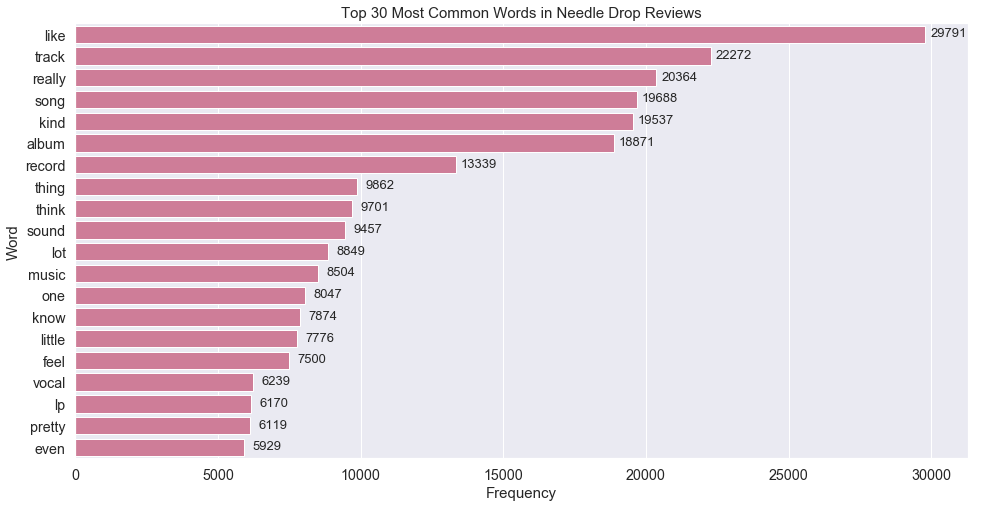

In [158]:
words, freqs = list(zip(*dist.most_common(20)))
words = list(words)
freqs = list(freqs)

sns.set(font_scale = 1.3)
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(x=freqs, y=words, ax=ax, color='palevioletred')
ax.set_title('Top 30 Most Common Words in Needle Drop Reviews', fontsize=15)
ax.set_ylabel('Word', fontsize=15)
ax.set_xlabel('Frequency', fontsize=15)
for p in ax.patches:
    width = p.get_width()
    ax.text(p.get_width() + 800,
            p.get_y()+p.get_height()-0.3,
            '{:1.0f}'.format(width),
            ha="center", fontsize=13)

In [159]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

mask = np.array(Image.open('../media/fantano_mask.png'))
wordcloud = WordCloud(background_color='white', width=2000, height=1600, mask=mask, max_font_size=90)\
.generate(' '.join(wordlist))
image_colors = ImageColorGenerator(mask)

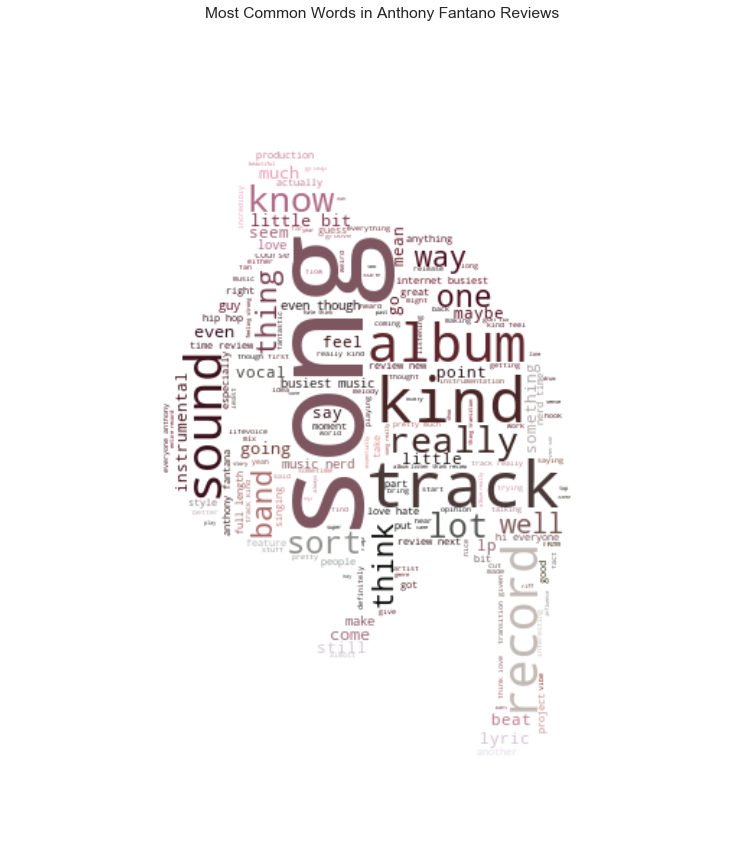

In [160]:
fig, ax = plt.subplots(figsize=(14,12))
ax.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
ax.set_title('Most Common Words in Anthony Fantano Reviews')
ax.axis('off')
plt.tight_layout()
plt.savefig('../media/mostcommoncloud.png', transparent=False)

## Most Controversial Reviews

To calculate the controversy score of each review, we use the following formula: $\frac{Total votes}{max(abs(likes-dislikes),1)}$

In [130]:
reviews['controversy'] = reviews.apply(lambda row: (row['like_count'] + row['dislike_count'])/max(abs(row['like_count'] - row['dislike_count']), 1), axis=1)

In [131]:
most_controversial = reviews.sort_values('controversy', ascending=False).head(20)

Text(0.5, 0, 'Controversy Score')

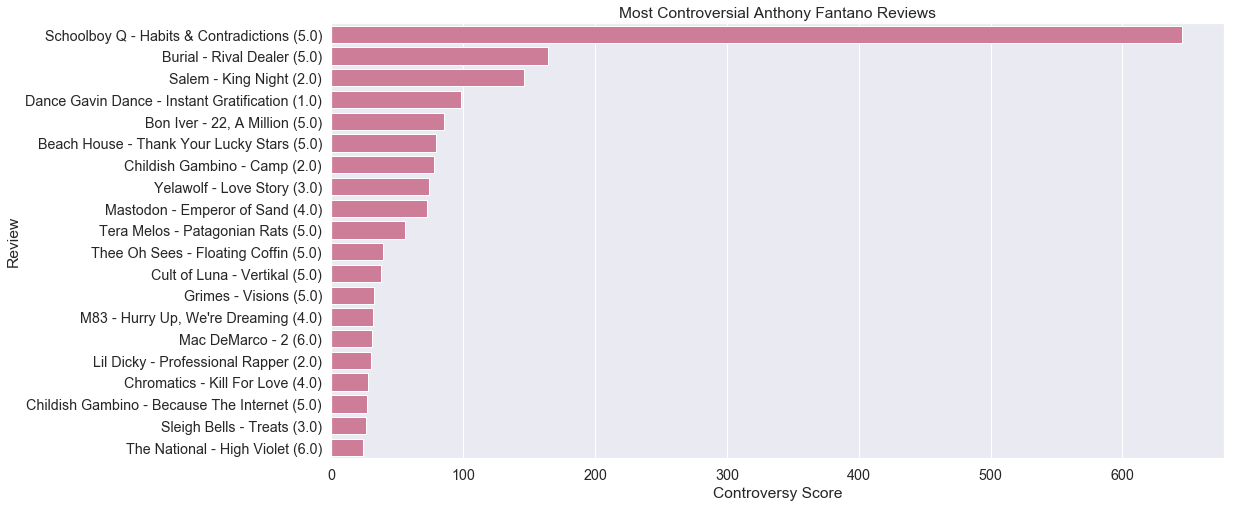

In [132]:
most_controversial['desc'] = most_controversial.apply(lambda row: '{} - {} ({})'.format(row['artist'], row['title'], row['score']), axis=1)

fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(x='controversy', y='desc', ax=ax, data=most_controversial, color='palevioletred')
ax.set_title('Most Controversial Anthony Fantano Reviews')
ax.set_ylabel('Review')
ax.set_xlabel('Controversy Score')

## TF-IDF To Generate Word Clouds for each genre

The TF-IDF is a nice statistical metric that reflects the importance of each word to a particular document in a set of documents. In our case, we calculate the importance of each word to a particular genre. We can then use the score of each word to draw a genre-specific word cloud.

The code to calculate the TF, IDF, and TF-IDF was taken from [this source](https://towardsdatascience.com/tfidf-for-piece-of-text-in-python-43feccaa74f8).

In [145]:
genres = list(text.genre.value_counts().index)
dists = []
doc_info = []
for genre in genres:
    corpus = text[text['genre'] == genre]['caption'].sum()
    dists.append({'id': genre, 'freqdist': FreqDist(corpus)})
    doc_info.append({'id': genre, 'length': len(corpus)})

In [146]:
def computeTF(doc_info, dists):
    TF_scores = []
    for i, dist in enumerate(dists):
        id = dist['id']
        for k in dist['freqdist']:
            temp = {'id': id,
                    'TF_score': dist['freqdist'][k]/doc_info[i]['length'],
                    'key': k}
            TF_scores.append(temp)
    return TF_scores

def computeIDF(doc_info, dists):
    IDF_scores = []
    for dist in dists:
        id = dist['id']
        for k in dist['freqdist']:
            count = sum([k in dist['freqdist'] for dist in dists])
            temp = {'id': id,
                   'IDF_score': math.log(len(doc_info)/count),
                   'key': k}
            IDF_scores.append(temp)
    return IDF_scores

def computeTFIDF(TF_scores, IDF_scores):
    TFIDF_scores = []
    for (TF, IDF) in zip(TF_scores, IDF_scores):
        if TF['id'] == IDF['id'] and TF['key'] == IDF['key']:
            TFIDF_scores.append({'id': TF['id'], 'TFIDF_score': TF['TF_score'] * IDF['IDF_score'], 'key': TF['key']})
    return TFIDF_scores

TF_scores = computeTF(doc_info, dists)
IDF_scores = computeIDF(doc_info, dists)

TFIDF_scores = computeTFIDF(TF_scores, IDF_scores)

In [147]:
scores = pd.DataFrame(TFIDF_scores).set_index('key')
score_dict = []
for genre in genres:
    score_dict.append(scores[scores['id'] == genre]['TFIDF_score'].to_dict())

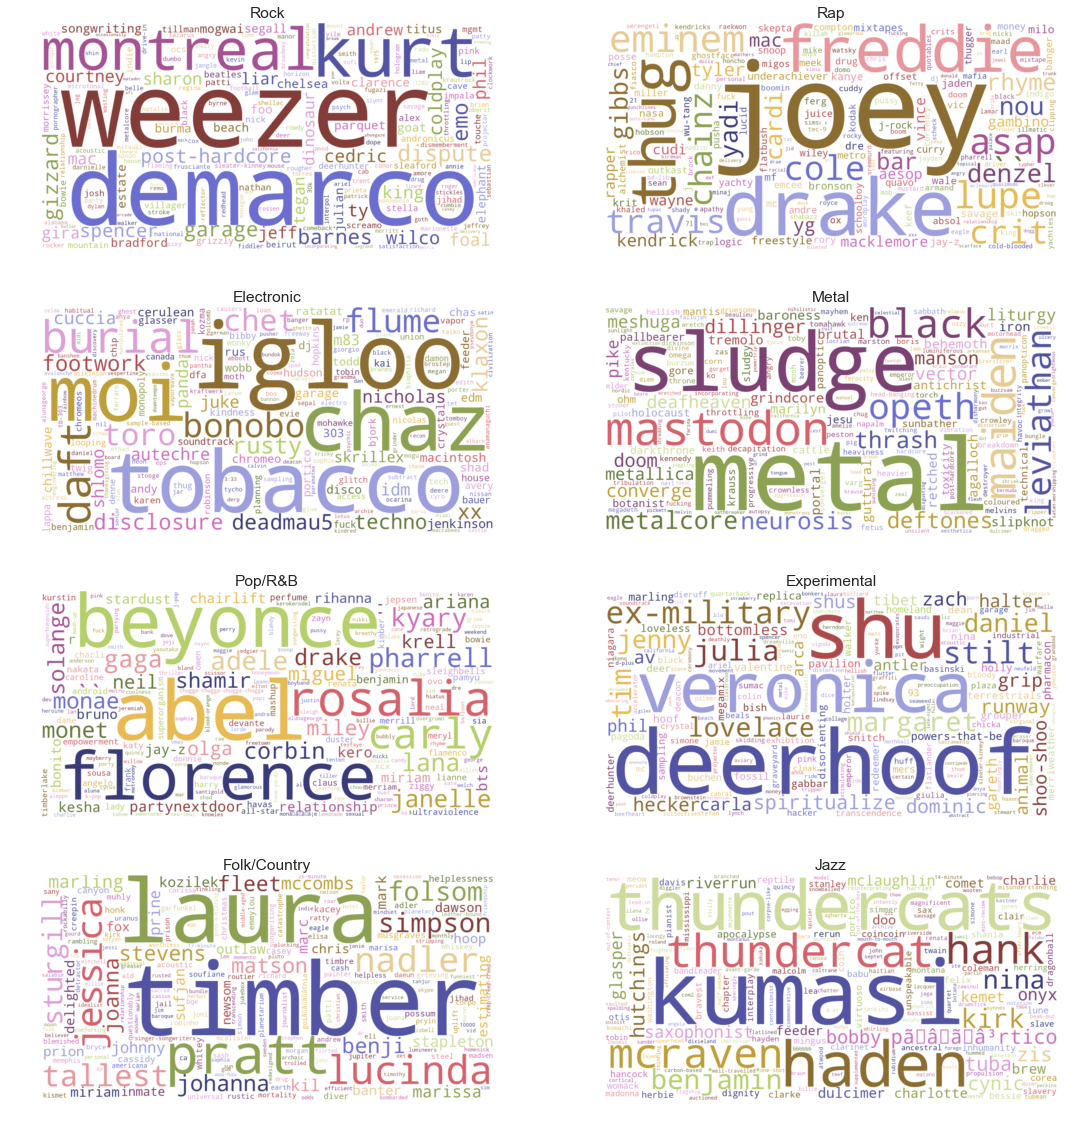

In [148]:
wordcloud = WordCloud(background_color='white', width=1600, height=800, colormap=plt.get_cmap('tab20b'))

fig = plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
for i, genre in enumerate(genres[:8]):
    wordcloud.generate_from_frequencies(score_dict[i])
    ax=fig.add_subplot(420+i+1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(genre)
    ax.axis('off')
plt.tight_layout()
plt.savefig('../media/genrecloud.png', transparent=False)

## TF-IDF for each year

We do the same for each review upload year.

In [149]:
text['year'] = text['review_date'].apply(lambda x: x.year)

In [150]:
years = list(text.year.value_counts().sort_index().index)
dists = []
doc_info = []
for year in years:
    corpus = text[text['year'] == year]['caption'].sum()
    dists.append({'id': year, 'freqdist': FreqDist(corpus)})
    doc_info.append({'id': year, 'length': len(corpus)})

In [151]:
TF_scores = computeTF(doc_info, dists)
IDF_scores = computeIDF(doc_info, dists)

TFIDF_scores = computeTFIDF(TF_scores, IDF_scores)

In [152]:
scores = pd.DataFrame(TFIDF_scores).set_index('key')
score_dict = []
for year in years:
    score_dict.append(scores[scores['id'] == year]['TFIDF_score'].to_dict())


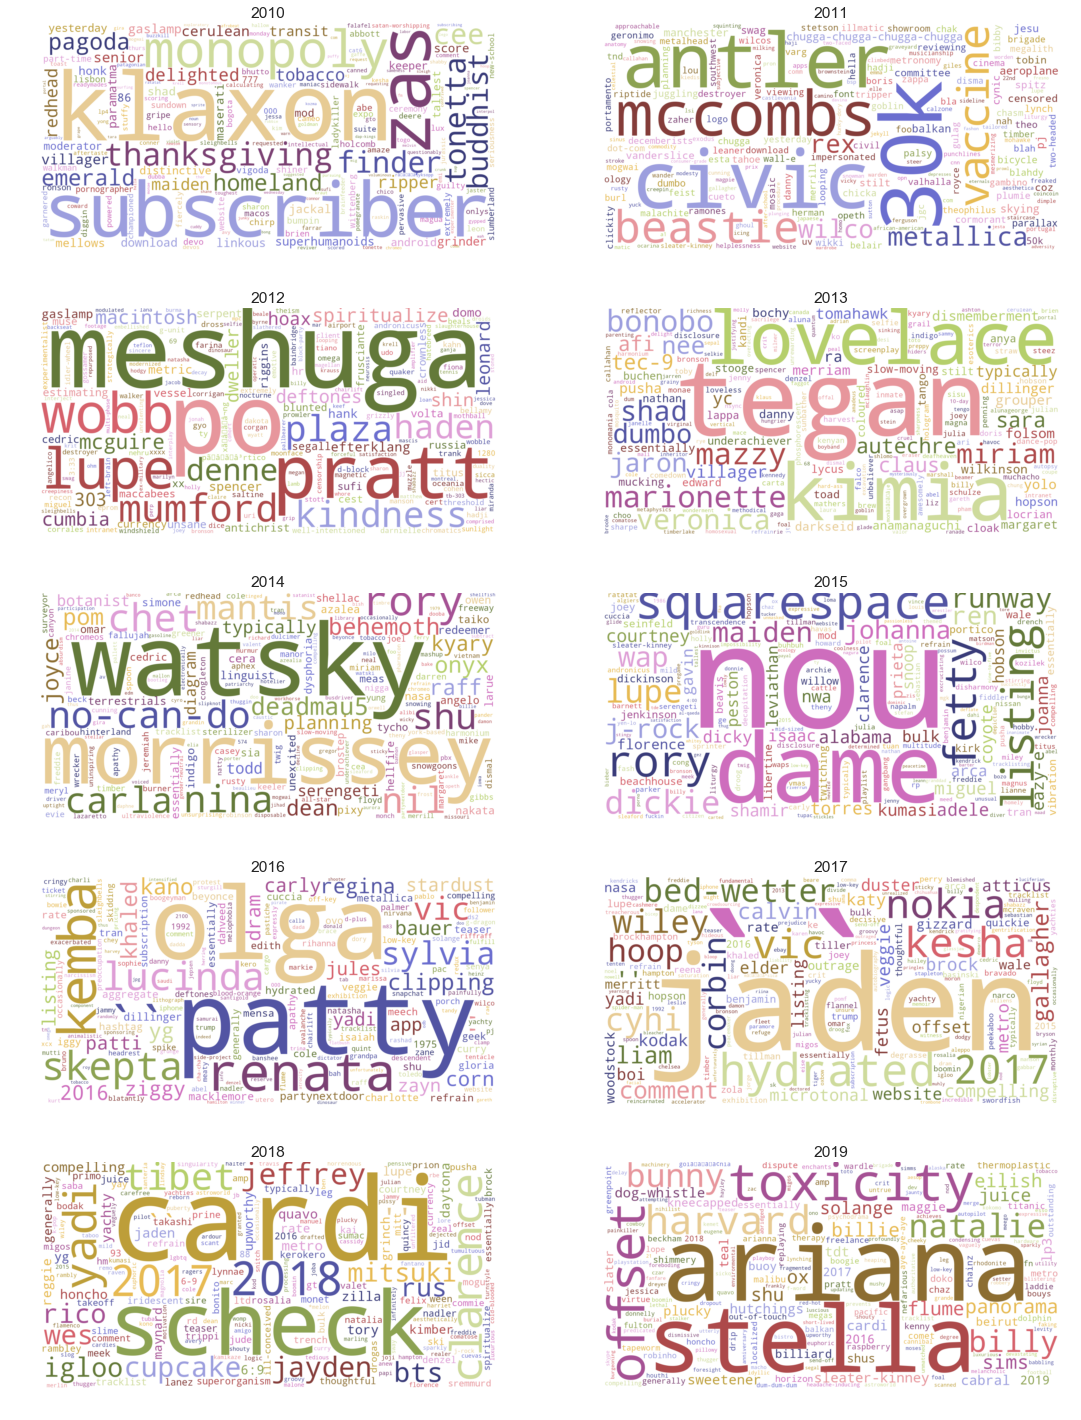

In [153]:
wordcloud = WordCloud(background_color='white', width=1600, height=800, colormap=plt.get_cmap('tab20b'))

fig = plt.figure(figsize=(16,20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
for i, year in enumerate(years):
    wordcloud.generate_from_frequencies(score_dict[i])
    ax=fig.add_subplot(5, 2, i+1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(year)
    ax.axis('off')
plt.tight_layout()
plt.savefig('../media/yearcloud.png', transparent=False)

## Sentiment Analysis to Visualize Positive and Negative Words

Next, we calculate the sentiment score for all of the words to create a word cloud of the most frequent positive and negative words.

In [154]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

poswordlist = []
negwordlist = []

sia = SentimentIntensityAnalyzer()

for word in wordlist:
    if (sia.polarity_scores(word)['compound']) >= 0.5:
        poswordlist.append(word)
    elif (sia.polarity_scores(word)['compound']) <= -0.5:
        negwordlist.append(word)

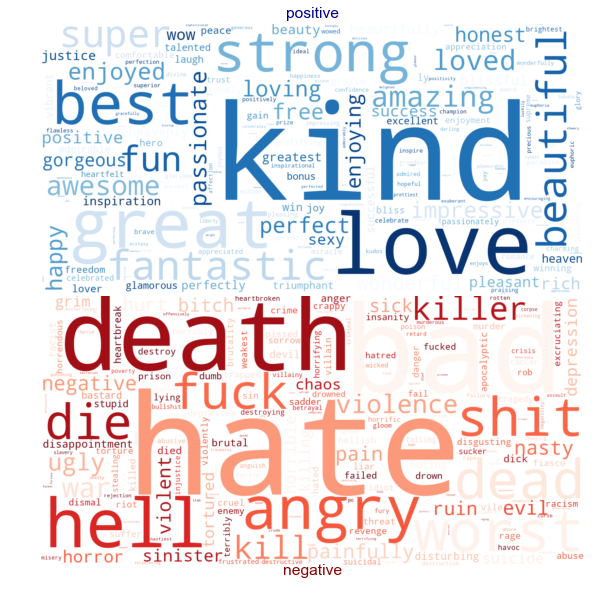

In [161]:
posdist = FreqDist(poswordlist)
negdist = FreqDist(negwordlist)

poswordcloud = WordCloud(background_color='white', width=1600, height=800, colormap=plt.get_cmap('Blues'))\
                .generate_from_frequencies(posdist)
negwordcloud = WordCloud(background_color='white', width=1600, height=800, colormap=plt.get_cmap('Reds'))\
                .generate_from_frequencies(negdist)

fig = plt.figure(figsize=(12,10))
plt.subplots_adjust(wspace=0.1, hspace=0)


ax1 = fig.add_subplot(2,1,1)
ax1.imshow(poswordcloud, interpolation='bilinear')
ax1.set_title('positive', color='darkblue')
ax1.axis('off')

ax2 = fig.add_subplot(2,1,2)
ax2.imshow(negwordcloud, interpolation='bilinear')
ax2.set_title('negative', color='darkred', y=-0.05)
ax2.axis('off')

plt.savefig('../media/posnegcloud.png', transparent=False)

## Pitchfork vs Anthony Fantano Reviews

We see that Pitchfork's scores are generally higher than Anthony's. Perhaps, Anthony chooses to review albums that he likes and dislikes alike. 

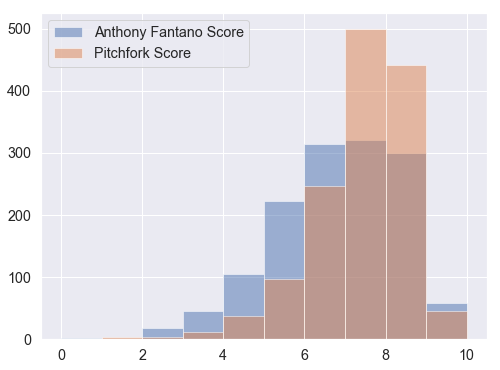

In [144]:
scored_reviews = reviews[(~reviews['score'].isnull()) & (~reviews['pitchfork_score'].isnull())]

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(scored_reviews['score'], bins=range(11), alpha=0.5, label='Anthony Fantano Score')
ax.hist(scored_reviews['pitchfork_score'], bins=range(11), alpha=0.5, label='Pitchfork Score')
ax.legend()
